In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from aeon.datasets import load_classification
import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product
from einops import rearrange

import models.original_models as original_models
import models.models_3d_atomics_on_variate_to_concepts as new_models
from vasopressor.preprocess_helpers import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_selection

gpu_id = int(subprocess.check_output('nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader | nl -v 0 | sort -nrk 2 | cut -f 1 | head -n 1 | xargs', shell=True, text=True))
device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available else torch.device('cpu')
print("current device", device)

current device cuda:8


In [2]:
X, y = load_classification("Tiselac", extract_path="/workdir/data")
print(" Shape of X = ", X.shape, type(X), X.dtype)
print(" Shape of y = ", y.shape, type(y), y.dtype)
y = y.astype(int)
display(y)


 Shape of X =  (99687, 10, 23) <class 'numpy.ndarray'> float64
 Shape of y =  (99687,) <class 'numpy.ndarray'> <U1


array([6, 1, 6, ..., 3, 4, 5])

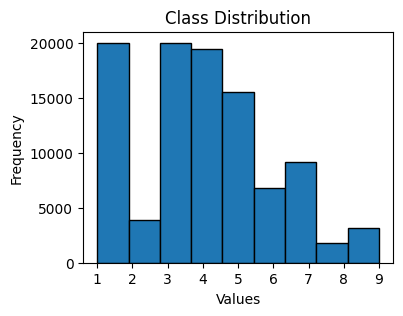

In [3]:
plt.figure(figsize=(4, 3))
plt.hist(y, bins=len(np.unique(y)), edgecolor='black')
plt.xticks(np.unique(y))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

In [4]:
def preprocess_data(_X, _y, batch_size = 512, random_state = 1):
    _X = rearrange(_X, "b t v -> b v t")

    ## target
    _y = _y-1
    y_unique = np.unique(_y)
    num_classes = len(y_unique)
    
    # class weights
    weights = compute_class_weight(class_weight='balanced', classes=y_unique, y=_y)
    weights = torch.Tensor(weights).to(device)
    
    # split 60/20/20 %
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size = 0.40, random_state = random_state, stratify = _y)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = random_state, stratify = y_test)

    # normalize
    X_train, X_val, X_test = normalize_across_time(X_train, X_val, X_test)

    # tensor
    X_train_pt = torch.tensor(X_train)
    X_train_pt = add_indicators(X_train_pt).to(dtype=torch.float32)
    y_train_pt = torch.tensor(y_train)

    X_val_pt = torch.tensor(X_val)
    X_val_pt = add_indicators(X_val_pt).to(dtype=torch.float32)
    y_val_pt = torch.tensor(y_val)

    X_test_pt = torch.tensor(X_test)
    X_test_pt = add_indicators(X_test_pt).to(dtype=torch.float32)
    y_test_pt = torch.tensor(y_test)
    
    # dataloader
    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4, pin_memory=False)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=False)

    test_dataset = TensorDataset(X_test_pt, y_test_pt)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=False)
    
    
    return train_loader, val_loader, test_loader, weights, num_classes


def add_indicators(data: torch.Tensor):
    indicators_3d = ~torch.isnan(data)
    data = torch.cat([data, indicators_3d], axis=-1) # (N x seq_len x 2*changing_dim)
    return data


def normalize_across_time(X_train, X_val, X_test):
    
    # scalerX=StandardScaler(with_std=False)
    scalerX=RobustScaler()
    n_variables = 10
    
    # N x T x V => N*T x V
    X_train_reshaped = X_train.reshape(-1, n_variables)
    X_val_reshaped = X_val.reshape(-1, n_variables)
    X_test_reshaped = X_test.reshape(-1, n_variables)

    nX_train = scalerX.fit_transform(X_train_reshaped)
    nX_val = scalerX.transform(X_val_reshaped)
    nX_test = scalerX.transform(X_test_reshaped)
    
    # revert shape
    nX_train = nX_train.reshape(X_train.shape)
    nX_val = nX_val.reshape(X_val.shape)
    nX_test = nX_test.reshape(X_test.shape)
    
    return nX_train, nX_val, nX_test


In [5]:
train_loader, val_loader, test_loader, class_weights, num_classes = preprocess_data(X, y)

print(class_weights, num_classes)

for a,b in train_loader:
    print(a.shape, a.device)
    print(b.shape, b.device)
    break

len(train_loader)

tensor([0.5538, 2.8525, 0.5538, 0.5710, 0.7132, 1.6248, 1.2057, 6.3149, 3.5524],
       device='cuda:8') 9
torch.Size([512, 23, 20]) cpu
torch.Size([512]) cpu


117

In [6]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()

def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "auc", "acc", "f1"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["auc"], label='AUC')
    plt.plot(mean_atomics.index, mean_atomics["acc"], label='ACC')
    plt.plot(mean_atomics.index, mean_atomics["f1"], label='F1')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["auc"], label='AUC')
    plt.plot(mean_concepts.index, mean_concepts["acc"], label='ACC')
    plt.plot(mean_concepts.index, mean_concepts["f1"], label='F1')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()


In [7]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, 
                    use_indicators, use_fixes, use_only_last_timestep, top_k=''):
    model = original_models.CBM(input_dim = input_dim, 
                                changing_dim = changing_dim, 
                                seq_len = seq_len,
                                num_concepts = n_concepts,
                                use_indicators = use_indicators,
                                use_fixes = use_fixes,
                                use_only_last_timestep = use_only_last_timestep,
                                use_grad_norm = False,
                                opt_lr = 1e-3,
                                opt_weight_decay = 1e-5,
                                l1_lambda=1e-3,
                                cos_sim_lambda=1e-2,
                                output_dim = output_dim,
                                top_k=top_k,
                                device = device
                                )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim, 
                                 use_summaries_for_atomics, use_indicators, use_fixes, top_k=''):
    model = new_models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics= n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            use_indicators = use_indicators,
                            use_fixes = use_fixes,
                            use_grad_norm = False,
                            opt_lr = 1e-3,
                            opt_weight_decay = 1e-5,
                            l1_lambda=1e-3,
                            cos_sim_lambda=1e-2,
                            output_dim = output_dim,
                            top_k=top_k,
                            device = device
                            )
    model = model.to(device)
    return model


In [8]:

auroc_metric = AUROC(task="multiclass", num_classes=num_classes).to(device)
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes).to(device)
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)

seq_len = X.shape[2]
changing_dim = X.shape[1]
input_dim = 2 * changing_dim

print(changing_dim, input_dim, seq_len)

random_seed = 1
set_seed(random_seed)


10 20 23


## Original

In [9]:
config_original = {
    "n_concepts": [4, 20],
    "use_indicators": [True, False],
    "use_fixes": [False, True],
    "use_only_last_timestep": [False]
}

all_config_permutations_og = list(product(*config_original.values()))
all_config_permutations_og = [dict(zip(config_original.keys(), permutation)) for permutation in all_config_permutations_og]
print(len(all_config_permutations_og))
# all_config_permutations_og

8


In [10]:
experiment_folder = "/workdir/optimal-summaries-public/_models/tiselac/original/"
model_path = experiment_folder + "tiselac_c{n_concepts}_ind{use_indicators}_fixes{use_fixes}_onlylasttimestep{use_only_last_timestep}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [11]:
histories_original = []

for i, config in enumerate(all_config_permutations_og):
    print(i, config)
    
    train_loader, val_loader, test_loader, class_weights, num_classes = preprocess_data(X, y)
    
    model = initializeModel(**config, input_dim=input_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=num_classes)
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config), max_epochs=10000)
    
    cos_sim = (model.cos_sim(model.bottleneck) / model.bottleneck.out_features).item()
    
    model.eval()
    with torch.inference_mode():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            probs = model.forward_probabilities(Xb)
                        
            auc = auroc_metric(probs, yb).item()
            acc = accuracy_metric(probs, yb).item()
            f1 = f1_metric(probs, yb).item()
            # conf_matrix(probs, yb)
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        f1 = f1_metric.compute().item()
        # conf_matrix.plot()
        # plt.show()
        auroc_metric.reset()
        accuracy_metric.reset()
        # conf_matrix.reset()
        f1_metric.reset()
    
    history = ["original", i, model.val_losses[-1], auc, acc, f1, cos_sim]
    print(history)
    histories_original.append(np.array(history))
    
    # plot_losses(model.train_losses, model.val_losses)
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
histories_original = np.array(histories_original)
histories_original.shape


0 {'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/tiselac_c4_indTrue_fixesFalse_onlylasttimestepFalse.pt
['original', 0, 0.8138248920440674, 0.9637631177902222, 0.7724331617355347, 0.7724331617355347, 0.0007879092590883374]
1 {'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/tiselac_c4_indTrue_fixesTrue_onlylasttimestepFalse.pt
['original', 1, 0.809232234954834, 0.9652386903762817, 0.7832171320915222, 0.7832171320915222, 0.0004811086691915989]
2 {'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/tiselac_c4_indFalse_fixesFalse_onlylasttimestepFalse.pt
['original', 2, 0.8391594290733337, 0.9620999097824097, 0.775242030620575, 0.775242030620575, 0.00048380717635154724]
3 {'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/tiselac_c4_indFalse_fixesTrue_onlylasttimestepFalse.pt
['original', 3, 0.843997061252594, 0.9600985050201416, 0.771279513835907, 0.771279513835907, 0.00023292051628232002]
4 {'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/tiselac_c20_indTrue_fixesFalse_onlylasttimestepFalse.pt
['original', 4, 0.7627323269844055, 0.971844494342804, 0.8053368330001831, 0.8053368330001831, 0.006136160343885422]
5 {'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/tiselac_c20_indTrue_fixesTrue_onlylasttimestepFalse.pt
['original', 5, 0.7515054941177368, 0.9731186628341675, 0.805938720703125, 0.805938720703125, 0.005152598489075899]
6 {'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/tiselac_c20_indFalse_fixesFalse_onlylasttimestepFalse.pt
['original', 6, 0.7649664878845215, 0.9711315631866455, 0.7941014170646667, 0.7941014170646667, 0.005714248400181532]
7 {'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/tiselac_c20_indFalse_fixesTrue_onlylasttimestepFalse.pt
['original', 7, 0.7775368094444275, 0.9710257053375244, 0.8011235594749451, 0.8011235594749451, 0.006689111236482859]


(8, 7)

In [12]:
# plot
# plot_metrics(histories_original, n_concepts_list)


## Atomics

In [13]:
config_atomics = {
    "n_atomics": [10, 30],
    "n_concepts": [4, 20],
    "use_indicators": [True, False],
    "use_fixes": [False, True],
    # "use_only_last_timestep": [True, False],
    "use_summaries_for_atomics": [True, False],
}

all_config_permutations_atomics = list(product(*config_atomics.values()))
all_config_permutations_atomics = [dict(zip(config_atomics.keys(), permutation)) for permutation in all_config_permutations_atomics]
print(len(all_config_permutations_atomics))
# all_config_permutations_atomics

32


In [14]:
experiment_folder = "/workdir/optimal-summaries-public/_models/tiselac/atomics/"
model_path = experiment_folder + "tiselac_c{n_atomics}_c{n_concepts}_ind{use_indicators}_fixes{use_fixes}_summaries{use_summaries_for_atomics}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [15]:
history_atomics = []

for i, config in enumerate(all_config_permutations_atomics):
    print(i, config)
    
    train_loader, val_loader, test_loader, class_weights, num_classes = preprocess_data(X, y)#, batch_size=8)
    
    model = initializeModel_with_atomics(**config, input_dim=input_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim = num_classes)
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config), max_epochs=10000)
    
    cos_sim = ((model.cos_sim(model.layer_to_concepts) + model.cos_sim(model.layer_time_to_atomics)) 
               / (model.layer_to_concepts.out_features + model.layer_time_to_atomics.out_features)).item()
    
    model.eval()
    with torch.inference_mode():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            probs = model.forward_probabilities(Xb)
            
            auc = auroc_metric(probs, yb).item()
            acc = accuracy_metric(probs, yb).item()
            f1 = f1_metric(probs, yb).item()
            # conf_matrix(probs, yb)
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        f1 = f1_metric.compute().item()
        # conf_matrix.plot()
        # plt.show()
        auroc_metric.reset()
        accuracy_metric.reset()
        # conf_matrix.reset()
        f1_metric.reset()

    history = ["atomics", i, model.val_losses[-1], auc, acc, f1, cos_sim]
    print(history)
    history_atomics.append(np.array(history))
    
    # plot_losses(model.train_losses, model.val_losses)
    del model
    gc.collect()
    torch.cuda.empty_cache()

    
history_atomics = np.array(history_atomics)
history_atomics.shape


0 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c4_indTrue_fixesFalse_summariesTrue.pt
['atomics', 0, 0.8547009229660034, 0.9614691138267517, 0.7609971165657043, 0.7609971165657043, 0.0039618900045752525]
1 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c4_indTrue_fixesFalse_summariesFalse.pt
['atomics', 1, 0.8573909401893616, 0.9590299725532532, 0.766664981842041, 0.766664981842041, 0.006042663939297199]
2 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c4_indTrue_fixesTrue_summariesTrue.pt
['atomics', 2, 0.8602383136749268, 0.962300181388855, 0.7745899558067322, 0.7745899558067322, 0.004117134027183056]
3 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c4_indTrue_fixesTrue_summariesFalse.pt
['atomics', 3, 0.8611301779747009, 0.958334743976593, 0.7508150935173035, 0.7508150935173035, 0.0053949481807649136]
4 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c4_indFalse_fixesFalse_summariesTrue.pt
['atomics', 4, 0.8640652298927307, 0.9611229300498962, 0.7740381956100464, 0.7740381956100464, 0.0041381134651601315]
5 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c4_indFalse_fixesFalse_summariesFalse.pt
['atomics', 5, 0.8980997204780579, 0.9543002247810364, 0.757084846496582, 0.757084846496582, 0.008012873120605946]
6 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c4_indFalse_fixesTrue_summariesTrue.pt
['atomics', 6, 0.8716155886650085, 0.9605028629302979, 0.7598435282707214, 0.7598435282707214, 0.0045175980776548386]
7 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c4_indFalse_fixesTrue_summariesFalse.pt
['atomics', 7, 0.8906461596488953, 0.954555094242096, 0.7520689964294434, 0.7520689964294434, 0.009425458498299122]
8 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c20_indTrue_fixesFalse_summariesTrue.pt
['atomics', 8, 0.8098080158233643, 0.9683555960655212, 0.7867282032966614, 0.7867282032966614, 0.009448070079088211]
9 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c20_indTrue_fixesFalse_summariesFalse.pt
['atomics', 9, 0.7911016345024109, 0.967433750629425, 0.7843707799911499, 0.7843707799911499, 0.007826822809875011]
10 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c20_indTrue_fixesTrue_summariesTrue.pt
['atomics', 10, 0.8098523616790771, 0.9677066802978516, 0.7895871996879578, 0.7895871996879578, 0.009856680408120155]
11 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c20_indTrue_fixesTrue_summariesFalse.pt
['atomics', 11, 0.779026985168457, 0.9687927961349487, 0.7940011024475098, 0.7940011024475098, 0.006344075780361891]
12 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c20_indFalse_fixesFalse_summariesTrue.pt
['atomics', 12, 0.8171895146369934, 0.9669895172119141, 0.7874304056167603, 0.7874304056167603, 0.00967267993837595]
13 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c20_indFalse_fixesFalse_summariesFalse.pt
['atomics', 13, 0.8241443037986755, 0.9658754467964172, 0.7918944954872131, 0.7918944954872131, 0.007165620569139719]
14 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c20_indFalse_fixesTrue_summariesTrue.pt
['atomics', 14, 0.8225510716438293, 0.9673246741294861, 0.7869288325309753, 0.7869288325309753, 0.009143858216702938]
15 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c10_c20_indFalse_fixesTrue_summariesFalse.pt
['atomics', 15, 0.7962673306465149, 0.9687080383300781, 0.7976124882698059, 0.7976124882698059, 0.007072619162499905]
16 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c4_indTrue_fixesFalse_summariesTrue.pt
['atomics', 16, 0.8570713996887207, 0.9634325504302979, 0.7732858657836914, 0.7732858657836914, 0.014536398462951183]
17 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c4_indTrue_fixesFalse_summariesFalse.pt
['atomics', 17, 0.8790673017501831, 0.956577718257904, 0.7586396932601929, 0.7586396932601929, 0.013960089534521103]
18 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c4_indTrue_fixesTrue_summariesTrue.pt
['atomics', 18, 0.8573738932609558, 0.9637326002120972, 0.775593101978302, 0.775593101978302, 0.012066208757460117]
19 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c4_indTrue_fixesTrue_summariesFalse.pt
['atomics', 19, 0.8672535419464111, 0.9572823643684387, 0.7654110193252563, 0.7654110193252563, 0.014132418669760227]
20 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c4_indFalse_fixesFalse_summariesTrue.pt
['atomics', 20, 0.8956088423728943, 0.9607763290405273, 0.7718814015388489, 0.7718814015388489, 0.04475754126906395]
21 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c4_indFalse_fixesFalse_summariesFalse.pt
['atomics', 21, 0.9733768701553345, 0.9543054699897766, 0.752971887588501, 0.752971887588501, 0.22039665281772614]
22 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c4_indFalse_fixesTrue_summariesTrue.pt
['atomics', 22, 0.8863288760185242, 0.96119225025177, 0.7717309594154358, 0.7717309594154358, 0.044113535434007645]
23 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c4_indFalse_fixesTrue_summariesFalse.pt
['atomics', 23, 0.9832081198692322, 0.9527338147163391, 0.7588403224945068, 0.7588403224945068, 0.2212042361497879]
24 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c20_indTrue_fixesFalse_summariesTrue.pt
['atomics', 24, 0.8100447058677673, 0.9687737226486206, 0.7896875143051147, 0.7896875143051147, 0.012843810021877289]
25 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c20_indTrue_fixesFalse_summariesFalse.pt
['atomics', 25, 0.7812846899032593, 0.9697772264480591, 0.7977128028869629, 0.7977128028869629, 0.013408645987510681]
26 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c20_indTrue_fixesTrue_summariesTrue.pt
['atomics', 26, 0.8533369302749634, 0.9662958979606628, 0.7858253717422485, 0.7858253717422485, 0.01285081822425127]
27 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c20_indTrue_fixesTrue_summariesFalse.pt
['atomics', 27, 0.8107386827468872, 0.9669223427772522, 0.784521222114563, 0.784521222114563, 0.013472150079905987]
28 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c20_indFalse_fixesFalse_summariesTrue.pt
['atomics', 28, 0.8622366189956665, 0.9655028581619263, 0.7787029147148132, 0.7787029147148132, 0.03373926505446434]
29 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c20_indFalse_fixesFalse_summariesFalse.pt
['atomics', 29, 0.8996496796607971, 0.9666792750358582, 0.7855244278907776, 0.7855244278907776, 0.1524268537759781]
30 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c20_indFalse_fixesTrue_summariesTrue.pt
['atomics', 30, 0.8413392305374146, 0.9675185084342957, 0.7916436791419983, 0.7916436791419983, 0.0351271778345108]
31 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/tiselac_c30_c20_indFalse_fixesTrue_summariesFalse.pt
['atomics', 31, 0.8860554695129395, 0.9654920697212219, 0.7834679484367371, 0.7834679484367371, 0.1536286473274231]


(32, 7)

In [16]:
columns=["type", "config", "val_loss", "auc", "acc", "f1", "cos_sim"]
dtypes = {'type': str, 'config': int, 'val_loss': float, 'auc': float, 'acc': float, 'f1': float, 'cos_sim': float}

df_og = pd.DataFrame(histories_original, columns=columns).astype(dtypes)
df_og = pd.concat([df_og, pd.DataFrame(all_config_permutations_og)], axis=1)

df_atomics = pd.DataFrame(history_atomics, columns=columns).astype(dtypes)
df_atomics = pd.concat([df_atomics, pd.DataFrame(all_config_permutations_atomics)], axis=1)

result_df = pd.concat([df_og, df_atomics], ignore_index=True)
# result_df

In [17]:
for col in result_df.columns[3:6]:
    baseline = result_df[(result_df['type'] == 'original') & (result_df['config'] == 0)][col].values[0]
    print(col, baseline)
    result_df[f'{col}_abs_imp'] = result_df[col] - baseline
    # result_df[f'{col}_rel_imp'] = result_df[f'{col}_abs_imp'] / baseline
# result_df

auc 0.9637631177902222
acc 0.7724331617355347
f1 0.7724331617355347


In [18]:
pd.set_option('display.max_rows', 500)
result_df.sort_values(by='acc', ascending=False)
# atomics: atomics, concepts, use_indicators, use_fixes, output_dim, use_summaries_for_atomics
# original: concepts, use_indicators, use_fixes, output_dim, use_only_last_timestep


,type,config,val_loss,auc,acc,f1,cos_sim,n_concepts,use_indicators,use_fixes,use_only_last_timestep,n_atomics,use_summaries_for_atomics,auc_abs_imp,acc_abs_imp,f1_abs_imp
5,original,5,0.751505,0.973119,0.805939,0.805939,0.005153,20,True,True,False,NaN,NaN,0.009356,0.033506,0.033506
4,original,4,0.762732,0.971844,0.805337,0.805337,0.006136,20,True,False,False,NaN,NaN,0.008081,0.032904,0.032904
7,original,7,0.777537,0.971026,0.801124,0.801124,0.006689,20,False,True,False,NaN,NaN,0.007263,0.028690,0.028690
33,atomics,25,0.781285,0.969777,0.797713,0.797713,0.013409,20,True,False,NaN,30.0,False,0.006014,0.025280,0.025280
23,atomics,15,0.796267,0.968708,0.797612,0.797612,0.007073,20,False,True,NaN,10.0,False,0.004945,0.025179,0.025179
6,original,6,0.764966,0.971132,0.794101,0.794101,0.005714,20,False,False,False,NaN,NaN,0.007368,0.021668,0.021668
19,atomics,11,0.779027,0.968793,0.794001,0.794001,0.006344,20,True,True,NaN,10.0,False,0.005030,0.021568,0.021568
21,atomics,13,0.824144,0.965875,0.791894,0.791894,0.007166,20,False,False,NaN,10.0,False,0.002112,0.019461,0.019461
38,atomics,30,0.841339,0.967519,0.791644,0.791644,0.035127,20,False,True,NaN,30.0,True,0.003755,0.019211,0.019211
32,atomics,24,0.810045,0.968774,0.789688,0.789688,0.012844,20,True,False,NaN,30.0,True,0.005011,0.017254,0.017254


In [19]:
for key in sorted(set(list(all_config_permutations_og[0].keys()) + list(all_config_permutations_atomics[0].keys()))):
    display(result_df.groupby(["type", key])[["auc", "acc", "f1"]].mean())

display(result_df.groupby("type")[["auc", "acc", "f1"]].mean())

auc       acc        f1
type    n_atomics                              
atomics 10.0       0.963300  0.775916  0.775916
        30.0       0.962937  0.776590  0.776590

auc       acc        f1
type     n_concepts                              
atomics  4           0.958853  0.764029  0.764029
         20          0.967384  0.788477  0.788477
original 4           0.962800  0.775543  0.775543
         20          0.971780  0.801625  0.801625

auc       acc        f1
type     use_fixes                              
atomics  False      0.963150  0.776101  0.776101
         True       0.963087  0.776405  0.776405
original False      0.967210  0.786778  0.786778
         True       0.967370  0.790390  0.790390

auc       acc        f1
type     use_indicators                              
atomics  False           0.962099  0.775104  0.775104
         True            0.964139  0.777402  0.777402
original False           0.966089  0.785437  0.785437
         True            0.968491  0.791731  0.791731

,,auc,acc,f1
type,use_only_last_timestep,,,
original,False,0.96729,0.788584,0.788584


auc       acc        f1
type    use_summaries_for_atomics                              
atomics False                      0.961675  0.773850  0.773850
        True                       0.964562  0.778656  0.778656

,auc,acc,f1
type,,,
atomics,0.963119,0.776253,0.776253
original,0.967290,0.788584,0.788584


## Optimization

In [ ]:
# feature weights
n_concepts = 4

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
model.fit(train_loader, val_loader, class_weights, model_path.format(n_concepts), 1000)

for batch_idx, (Xb, yb) in enumerate(test_loader):
    Xb, yb = Xb.to(device), yb.to(device)
    probs = model.forward_probabilities(Xb)
    
    auc = auroc_metric(probs, yb).item()
    acc = accuracy_metric(probs, yb).item()
    conf_matrix(probs, yb)
auc = auroc_metric.compute().item()
acc = accuracy_metric.compute().item()
conf_matrix.plot()
auroc_metric.reset()
accuracy_metric.reset()
conf_matrix.reset()

print("AUC", auc)
print("ACC", acc)

In [ ]:
for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
V = 13 + 1
T = seq_len + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

In [ ]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [ ]:
greedy_results = greedy_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head(10)

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, class_weights, save_model_path="/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", max_epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()